## 7. QML로 VQE 결과 머신 러닝

VQE 의 결과 데이터를 불러와서 QML을 적용하였습니다.
- 


### 🙏 참고한 자료

In [2]:
import pandas as pd
import numpy as np
from qiskit_machine_learning.algorithms import QSVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler, StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#1. 데이터 전처리
df = pd.read_csv("data/fake-data-set.csv") 
print(df.head())

# molecule을 one-hot 인코딩
encoder = OneHotEncoder(sparse_output=False)
mol_encoded = encoder.fit_transform(df[["molecule"]])
mol_df = pd.DataFrame(mol_encoded, columns=encoder.get_feature_names_out(["molecule"]))

# 입력 특성 X, 출력값 y 구성
X = pd.concat([df[["num_qubits", "gate_count", "circuit_depth"]], mol_df], axis=1)
y = df["energy"]

# 1.1. 샘플 수 제한 (양자 커널은 느림)
X_small = X[:100]
y_small = y[:100]#ravel()
unique, counts = np.unique(y_small, return_counts=True)
print(dict(zip(unique, counts)))

# 1.2. PCA로 차원 축소
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_small)

# 1.3. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_small, test_size=0.2, random_state=42)

# 2. QSVM 준비
# 2.1. 양자 feature map 설정 (2-qubit ZZFeatureMap)
feature_map = PauliFeatureMap(feature_dimension=4, reps=3)

# 2.2. Quantum kernel 정의
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면 
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity = fidelity)

# 3. 학습
# 3.1. QSVM 학습용 커널 행렬 생성
# kernel_train = quantum_kernel.evaluate(x_vec=X_train)#양자커널 함수값 계산. X_train의 데이터 내의 유사성을 계산. fidelity(x_i,x_j)

# 3.2. SVM 학습 (precomputed kernel 사용)
qsvr = QSVR(quantum_kernel=quantum_kernel)
qsvr.fit(X_train, y_train)#kernel_train

# 4. 학습된 qvsm 으로 X_test 를 분류
# kernel_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
y_pred = qsvr.predict(X_test)



     molecule  num_qubits    energy  gate_count  circuit_depth
0  FakeMole_1           8 -1.051576           3              7
1  FakeMole_2           4 -0.505543           9              6
2  FakeMole_3           8 -1.324075           7              2
3  FakeMole_4           8 -1.481925           3              2
4  FakeMole_5           4 -1.006106           4              6
{np.float64(-1.4948151372260132): np.int64(1), np.float64(-1.4819246363844791): np.int64(1), np.float64(-1.4723832281262954): np.int64(1), np.float64(-1.461165265570577): np.int64(1), np.float64(-1.4589324832321242): np.int64(1), np.float64(-1.4563962282455662): np.int64(1), np.float64(-1.449231468960603): np.int64(1), np.float64(-1.429583869150456): np.int64(1), np.float64(-1.4290590830000722): np.int64(1), np.float64(-1.4246537439938718): np.int64(1), np.float64(-1.4184058195997595): np.int64(1), np.float64(-1.3672545777570302): np.int64(1), np.float64(-1.3633786685579712): np.int64(1), np.float64(-1.361646907582

In [4]:
# 4. 예측 및 평가
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1301


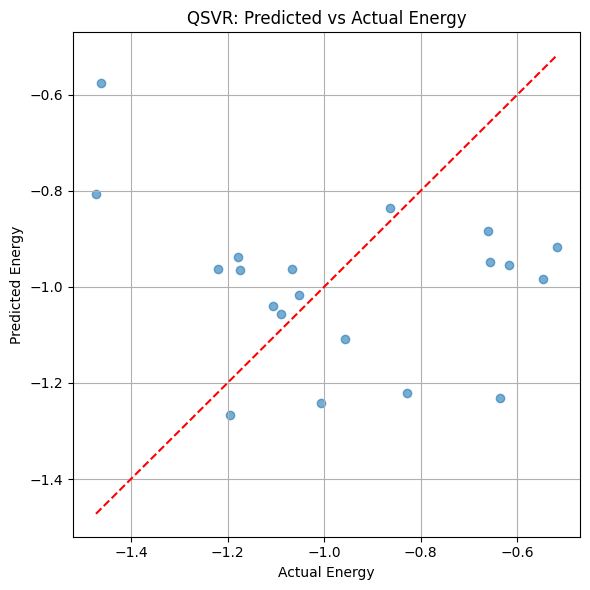

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.title("QSVR: Predicted vs Actual Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


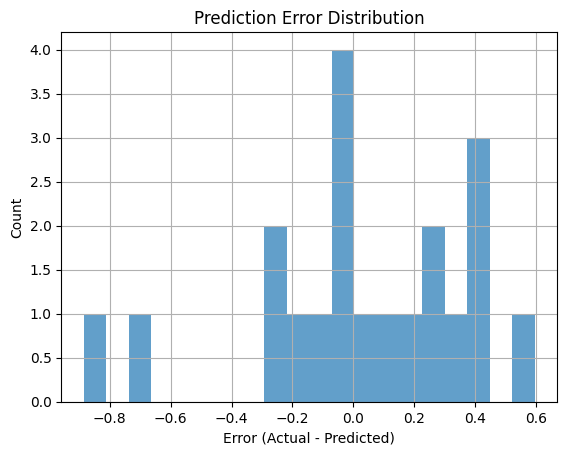

In [6]:
errors = y_test - y_pred
plt.hist(errors, bins=20, alpha=0.7)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [15]:
print("X_train.shape:", X_train.shape)
print("Feature map dimension:", feature_map.feature_dimension)

X_train.shape: (240, 4)
Feature map dimension: 240


## ✍️ 배운 점
- 

## 📌 다음 목표
- 


## 💭궁금한 점 및 추가 정보
#### 1. Sampler vs StatevectorSampler
|Sampler | StatevectorSampler |
| -- | -- |
|- 실제 양자 하드웨어처럼 측정(shots) 결과에서 확률 분포 추정 <br> - 예: $\ket{1}$ 상태가 1024샷 중 300번 나오면, 0.293으로 계산 <br> - 현실에 가까움 (noise 포함 가능) <br> - 실하드웨어 실험 가능| - 회로의 최종 상태벡터를 정확히 알고 있으므로, 확률이 아닌 진짜 내적(fidelity)을 바로 계산 <br>- VQE, 커널 평가에서 빠르고 정확|

In [ ]:
import pandas as pd
import numpy as np
from qiskit_machine_learning.algorithms import QSVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler, StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#1. 데이터 전처리
df = pd.read_csv("data/fake-data-set.csv") 
print(df.head())

# molecule을 one-hot 인코딩
encoder = OneHotEncoder(sparse_output=False)
mol_encoded = encoder.fit_transform(df[["molecule"]])
mol_df = pd.DataFrame(mol_encoded, columns=encoder.get_feature_names_out(["molecule"]))

# 입력 특성 X, 출력값 y 구성
X = pd.concat([df[["num_qubits", "gate_count", "circuit_depth"]], mol_df], axis=1)
y = df["energy"]

# 1.1. 샘플 수 제한 (양자 커널은 느림)
X_small = X[:300]
y_small = y[:300]#ravel()
unique, counts = np.unique(y_small, return_counts=True)
print(dict(zip(unique, counts)))

# 1.2. PCA로 차원 축소
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_small)

# 1.3. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_small, test_size=0.2, random_state=42)
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))
# 2. QSVM 준비
# 2.1. 양자 feature map 설정 (2-qubit ZZFeatureMap)
feature_map = PauliFeatureMap(feature_dimension=4, reps=3)

# 2.2. Quantum kernel 정의
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면 
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity = fidelity)

# 3. 학습
# 3.1. QSVM 학습용 커널 행렬 생성
kernel_train = quantum_kernel.evaluate(x_vec=X_train)#양자커널 함수값 계산. X_train의 데이터 내의 유사성을 계산. fidelity(x_i,x_j)

# 3.2. SVM 학습 (precomputed kernel 사용)
qsvr = QSVR(quantum_kernel=quantum_kernel)
qsvr.fit(kernel_train, y_train)

# 4. 학습된 qvsm 으로 X_test 를 분류
kernel_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
y_pred = qsvr.predict(kernel_test)



     molecule  num_qubits    energy  gate_count  circuit_depth
0  FakeMole_1           8 -1.051576           3              7
1  FakeMole_2           4 -0.505543           9              6
2  FakeMole_3           8 -1.324075           7              2
3  FakeMole_4           8 -1.481925           3              2
4  FakeMole_5           4 -1.006106           4              6
{np.float64(-1.4948151372260132): np.int64(1), np.float64(-1.4846954597096151): np.int64(1), np.float64(-1.4828388981682497): np.int64(1), np.float64(-1.4819246363844791): np.int64(1), np.float64(-1.4723832281262954): np.int64(1), np.float64(-1.4676840488903495): np.int64(1), np.float64(-1.461165265570577): np.int64(1), np.float64(-1.4610368676897665): np.int64(1), np.float64(-1.4608136733243535): np.int64(1), np.float64(-1.4589324832321242): np.int64(1), np.float64(-1.4565992167018271): np.int64(1), np.float64(-1.4563962282455662): np.int64(1), np.float64(-1.452283872308351): np.int64(1), np.float64(-1.45194107580

/var/folders/z0/3n_ywd1d7ngfl6cd55kbcn0c0000gn/T/ipykernel_51327/1580247221.py:46: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/z0/3n_ywd1d7ngfl6cd55kbcn0c0000gn/T/ipykernel_51327/1580247221.py:47: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면
